# Generative Adversarial Network

Generator and discriminator are build from scratch.

Using one and only MNIST dataset

In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [2]:
from keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys, os
from IPython import display
import glob
from functools import cmp_to_key

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
latent_dim = 100
batch_size = 32
epochs = 2000
sample_period = 100

In [5]:
# save a grid with generated images
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  imgs = 0.5 * imgs + 0.5 # range (0;1)

  fig, ax = plt.subplots(rows, cols)
  idx = 0

  for i in range(rows):
    for j in range(cols):
      ax[i,j].imshow(imgs[idx].reshape(H,W), cmap='gray')
      ax[i,j].axis('off')
      idx += 1
  
  fig.savefig(f"gan_images/{epoch}.png")
  plt.close()

## Dataset

In [6]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0 * 2 - 1 # (-1; 1) range
x_test = x_test / 255.0 * 2 - 1
print("x_train.shape: ", x_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
x_train.shape:  (60000, 28, 28)


In [7]:
# flattening the image to array
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

## Models

In [8]:
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)  # tanh bc image is scaled to (-1,1)

  model = Model(i,x)
  return model

In [9]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i,x)
  return model

combining and compiling models

In [10]:
discriminator = build_discriminator(D) # of the size of flattened image
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)
discriminator.trainable = False # only generator is trained

generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
img = generator(z)  # it makes image from noise
fake_pred = discriminator(img) # it classifies fake output

combined_model = Model(z, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [11]:
# batch labels (is the output fake or not)
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
for epoch in range(epochs):
  # discriminator is trained on real_imgs and fake_imgs separately
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones) # real images and labels "1" as positive class
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake) # summary (average) loss and accuracy
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  # generator is trained as the beginning of combined model
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)

epoch 1/2000, d_loss: 0.28, d_acc: 1.00, g_loss: 0.93
epoch 101/2000, d_loss: 0.01, d_acc: 1.00, g_loss: 4.75
epoch 201/2000, d_loss: 0.02, d_acc: 1.00, g_loss: 5.32
epoch 301/2000, d_loss: 0.06, d_acc: 1.00, g_loss: 4.46
epoch 401/2000, d_loss: 0.31, d_acc: 0.91, g_loss: 2.79
epoch 501/2000, d_loss: 0.68, d_acc: 0.47, g_loss: 0.72
epoch 601/2000, d_loss: 0.64, d_acc: 0.47, g_loss: 0.78
epoch 701/2000, d_loss: 0.61, d_acc: 0.61, g_loss: 0.75
epoch 801/2000, d_loss: 0.61, d_acc: 0.67, g_loss: 0.78
epoch 901/2000, d_loss: 0.65, d_acc: 0.62, g_loss: 0.73
epoch 1001/2000, d_loss: 0.61, d_acc: 0.80, g_loss: 0.81
epoch 1101/2000, d_loss: 0.62, d_acc: 0.70, g_loss: 0.85
epoch 1201/2000, d_loss: 0.57, d_acc: 0.73, g_loss: 0.88
epoch 1301/2000, d_loss: 0.59, d_acc: 0.69, g_loss: 0.83
epoch 1401/2000, d_loss: 0.62, d_acc: 0.78, g_loss: 0.91
epoch 1501/2000, d_loss: 0.56, d_acc: 0.81, g_loss: 0.87
epoch 1601/2000, d_loss: 0.60, d_acc: 0.67, g_loss: 0.90
epoch 1701/2000, d_loss: 0.59, d_acc: 0.69,

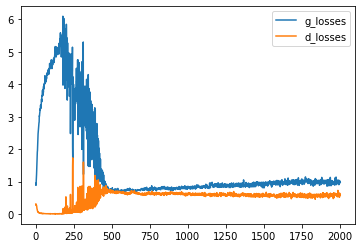

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()
plt.show()

In [ ]:
def sort_filenames(x1, x2):
    n1 = int(x1[:-4])
    n2 = int(x2[:-4])
    return n1 - n2

img_names = os.listdir('gan_images')
img_names.sort(key=cmp_to_key(sort_filenames))
print(f"Number of saved images:{len(img_names)}")

Number of saved images:20


['0.png',
 '100.png',
 '200.png',
 '300.png',
 '400.png',
 '500.png',
 '600.png',
 '700.png',
 '800.png',
 '900.png',
 '1000.png',
 '1100.png',
 '1200.png',
 '1300.png',
 '1400.png',
 '1500.png',
 '1600.png',
 '1700.png',
 '1800.png',
 '1900.png']

In [ ]:
img_list = []
for filename in img_names:
    img=image.load_img(os.path.join('gan_images', filename))
    img_list.append(img)

In [ ]:
len(img_list)

20

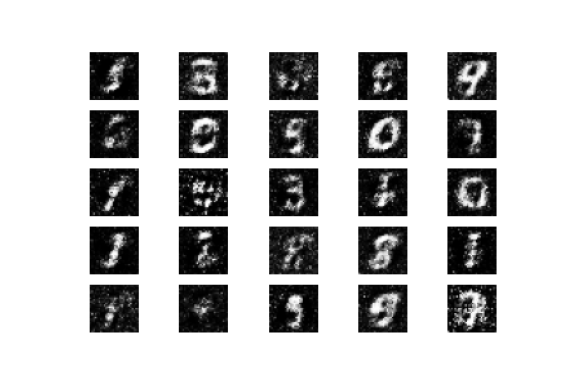

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(img, animated=True)] for img in img_list]
gif = animation.ArtistAnimation(fig, ims, interval=250, repeat_delay=250, blit=True)

display.HTML(gif.to_jshtml())